In [165]:
!pip install qiskit qiskit-aer

# Quantum Cross Correlation

Quantum Cross Correlation is a quantum version of the classical cross-correlation algorithm based on Fourier transformations. In essence, the classical computation of a correlation map $C_\text{map}$ uses the convolution theorem, which enables the use of Fast Fourier Transformations, denoted as $\mathcal{F}\{\cdot \}$. With the component-wise product '$\circ$', the correlation map is classically computed via 

$$C_\text{map} =\mathcal{F}^{-1}\{\mathcal{F}\{A \} \circ \mathcal{F}\{B \}  \}  $$

where $A$ and $B$ are the input signals. The correlation peak is where the map has its maximal entries and refers to the displacement of the input signals. For Particle Image Velocimetry, images of particles in a fluid are evaluated in this way to determine the flow velocity in the interrogation area. This programming project demonstrates this application for self-generated inputs.


## Input Generation

The first task is to generate input pairs which will then be subject to the correlation algorithm. 

Image 1:

* Generate a numpy array with $N^2$ entries where $N=2^n$ is the amount of pixels per edge in the quadratic image and $n=3$ is the amount of qubits.
* Generate N random integers in $0, 1, ..., N^2-1$. Use np.random.choice($N^2$,$N$) and define with np.random.seed(1) a random seed such that results are reproducible.
* Reshape the numpy array to an N$\times$N image with np.reshape( .. , (N,N))

Image 2: 

* For the beginning, we focus on simple periodic shifts by full cells. Use np.roll( ... ,(dx,dy),(x,y)) to shift the first image by one cell in both directions.


In the end, draw the images with matplotlib via plt.imshow( .. )

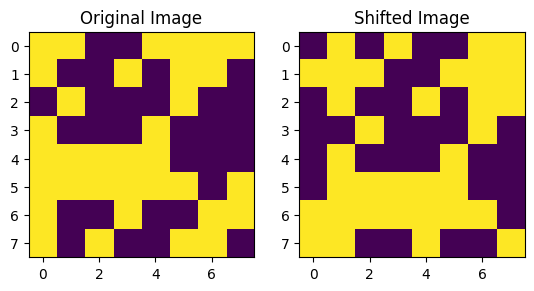

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n=3
N=2**n



# fill from here
np.random.seed(1)
A = np.random.choice([0, 1], size=N**2)

image1 = np.reshape(A, (N, N))
image2 = np.roll(image1, shift=(1, 1), axis=(0, 1))#Generation of an array of numbers from the range

# fill appropriately

plt.subplot(121)
plt.imshow(image1, cmap='viridis', interpolation='nearest' )
plt.title("Original Image")
plt.subplot(122)
plt.imshow(image2, cmap='viridis', interpolation='nearest' )
plt.title("Shifted Image")
plt.show()

## Classical Cross Correlation

Scipy has a correlate funtion which realizes the cross correlation between two data arrays. Use correlate to create the correlation map and draw the map as an image.

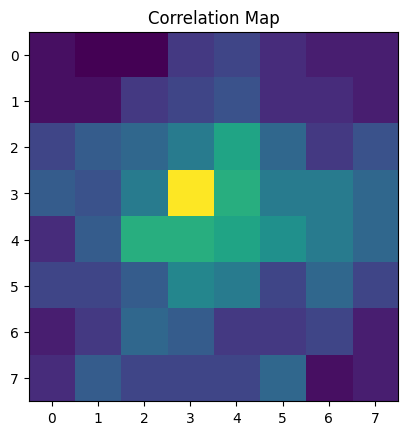

In [2]:
from scipy.signal import correlate
from scipy.signal import correlate2d

plt.imshow(correlate(image1, image2, mode='same'))
plt.title("Correlation Map")
plt.show()

## Quantum Cross-Correlation

Similar to the seminar, we can implement the 2D quantum cross correlation, where the key difference is that we need 2 smaller QFTs per image.
* Copy the code of the seminar and adapt it where necessary.
* Reshape the images back to one large vector, using np.reshape( ... , $N^2$). Initialize those two vectors on seperate qubit registers
* Place two equally sized QFTs in the positions where there was only one QFT before. For instance, the first image as a vector will span over 2n qubits. Place one QFT on list(range(n)) and the second on list(range(n,2*n)). Continue this for all other QFTs in the original algorithm.

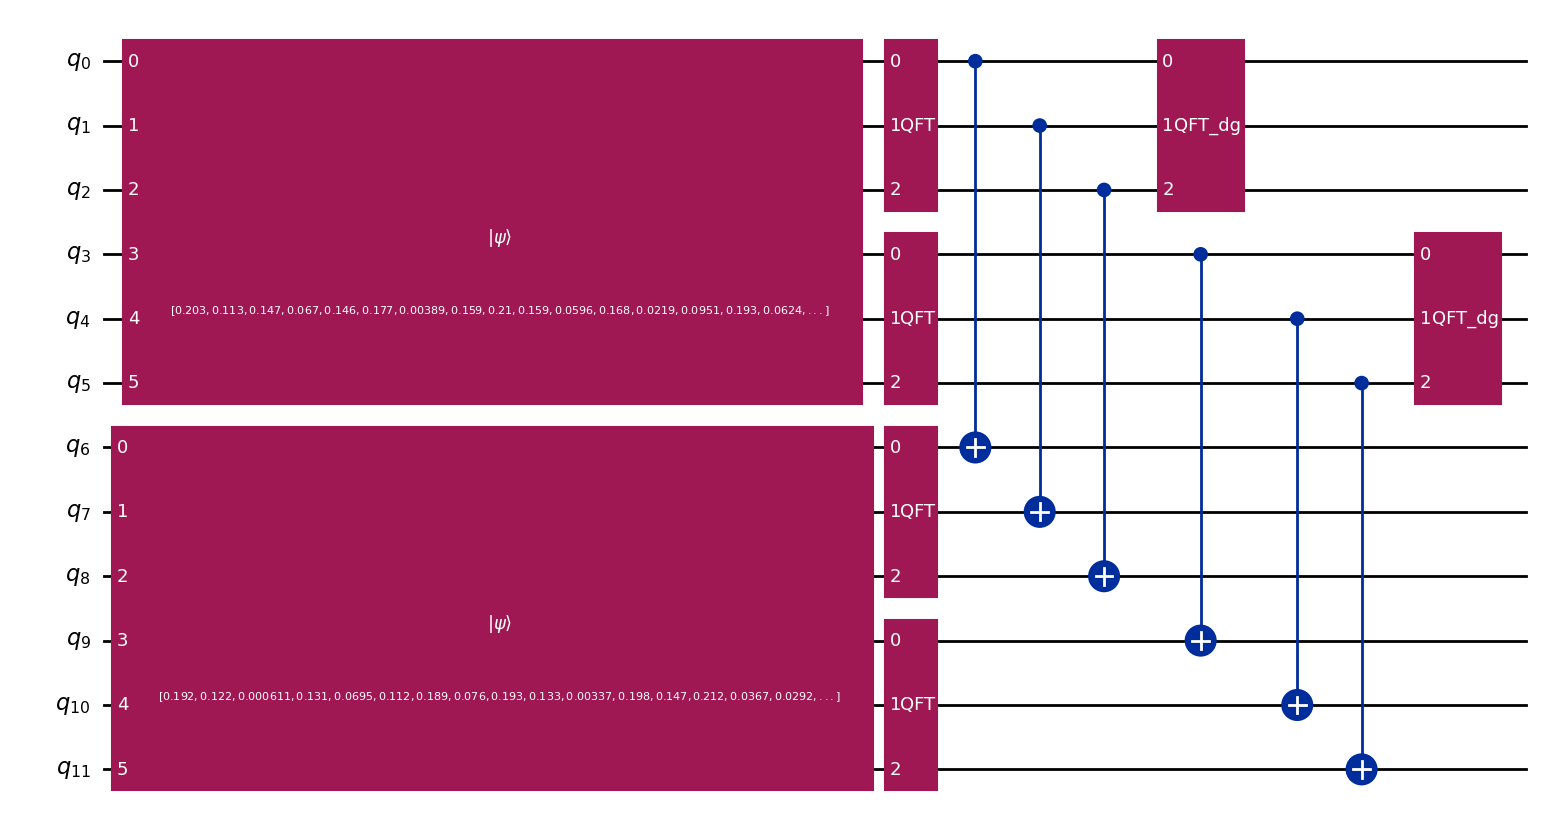

In [3]:
# from qiskit import QuantumCircuit
# Updated imports for newer Qiskit versions
from qiskit import QuantumCircuit
from qiskit_aer import Aer  # Changed from 'from qiskit import Aer'
from qiskit.primitives import StatevectorSampler  # New way to execute circuits
import numpy as np  # Added numpy import which was missing

# Rest of your code remains the same until the execution part
# When you need to execute the circuit, use this instead of the old execute():

# Initialize the simulator
simulator = Aer.get_backend('aer_simulator')
sampler = StatevectorSampler()

# The rest of your original code remains unchanged
# Define the number of qubits
n = 3  # log2 of one image dimension
N = 2 ** n  # Image size in one dimension (e.g., 8 for an 8x8 image)

def CreateQFT_Circ(QAmount, sign):
    """Creates a QFT circuit for QAmount qubits."""
    Circ = QuantumCircuit(QAmount, name="QFT")
    for k in range(QAmount):
        k_inv = QAmount - 1 - k
        Circ.h(k_inv)
        for kk in range(k_inv):
            Circ.cp(sign * np.pi / 2 ** (k_inv - kk), kk, k_inv)
    for kkk in range(QAmount // 2):
        Circ.swap(kkk, QAmount - 1 - kkk)
    return Circ

# Rest of your original code...
# Simulated images (replace with real images)
image1 = np.random.rand(N, N)  # Example 8x8 image
image2 = np.random.rand(N, N)  # Example 8x8 image

# Flatten images and normalize
vec1 = np.reshape(image1, N**2) / np.linalg.norm(image1.flatten())
vec2 = np.reshape(image2, N**2) / np.linalg.norm(image2.flatten())

# Create quantum circuit with 4n qubits (2n per image)
qc = QuantumCircuit(4 * n)

# Initialize the images into separate registers
qc.initialize(vec1, list(range(2 * n)))  # Image 1 on qubits [0, 1, ..., 2n-1]
qc.initialize(vec2, list(range(2 * n, 4 * n)))  # Image 2 on qubits [2n, ..., 4n-1]

# Apply two QFTs per image
qc.append(CreateQFT_Circ(n, 1), list(range(n)))  # QFT on first half of image1
qc.append(CreateQFT_Circ(n, 1), list(range(n, 2 * n)))  # QFT on second half of image1
qc.append(CreateQFT_Circ(n, -1), list(range(2 * n, 3 * n)))  # QFT on first half of image2
qc.append(CreateQFT_Circ(n, -1), list(range(3 * n, 4 * n)))  # QFT on second half of image2

# Apply controlled-X gates for entanglement
for k in range(2 * n):
    qc.cx(k, 2 * n + k)

# Apply inverse QFTs to extract correlation
qc.append(CreateQFT_Circ(n, 1).inverse(), list(range(n)))  # First half inverse QFT
qc.append(CreateQFT_Circ(n, 1).inverse(), list(range(n, 2 * n)))  # Second half inverse QFT

# Draw the circuit
qc.draw("mpl")
# plt.show()


Evaluate the quantum state and plot the resulting correlation map as an image. Remember that the result here is slightly different and half as large in each dimension as the classical calculation does the linear correlation, while for this project we will only do the circular correlation. Assure that the correlation peak is on the same position.

* Use the np.fft.fftshift function to sort the results properly.
* Reshape the result as before with np.reshape(.., ..)
* Use np.real(..) such that matplotlib can illustrate the image. Though the result is purely real, the quantum state will be defined with complex numbers, which causes problems for the plt.imshow(..) command.

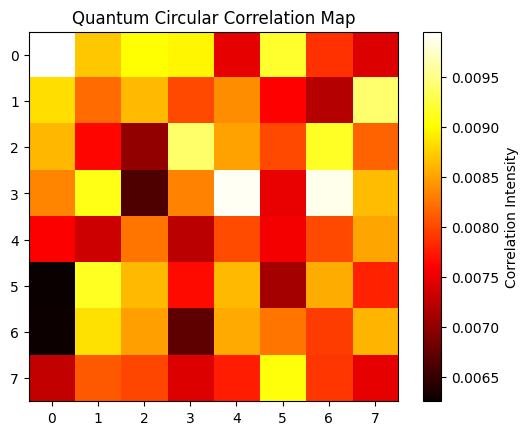

In [4]:
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Simulate the quantum state
state = Statevector(qc)
quantum_result = state.data  # Extract quantum state amplitudes

# Compute the probability distribution
correlation = np.abs(quantum_result) ** 2  # Squaring gives probabilities

# Select only the first N² elements (extracting the 8×8 portion)
correlation = correlation[:N**2]  # Keep only the first 64 values

# Reshape into an 8×8 array
correlation = np.reshape(correlation, (N, N))

# Use fftshift to align the correlation peak
correlation = np.fft.fftshift(correlation)

# Plot the correlation map
plt.imshow(np.real(correlation), cmap="hot", interpolation="nearest")
plt.colorbar(label="Correlation Intensity")
plt.title("Quantum Circular Correlation Map")
plt.show()


## Sampling

Implement the circuit above with measurements on all qubits and find out with how many shots are needed to identify the correlation peak correctly.

* For the identification of the amount of shots, it is recommended to plot the correlation map and check in which cases the correlation peak is at the correct position. Try to reduce the amount of shots as strong as possible and assure that in ~4/5 of all executions, the peak is on the right position.
* Copy the fundamental sampling code from the moodle page
* Use a copy of the last circuit and use measure_all() to avoid placing unintended measurements
* The following function helps to generate a np.array from the dictionary that .get_counts() produces

In [5]:
def get_vec_from_counts(Counts, Qubits):
    v = np.zeros(2**Qubits)
    for k in range(0,2**Qubits):
            key = format(k, '0' + str(Qubits)+'b')
            if key in Counts1:
                v[k] = Counts1[key]
                
    return v

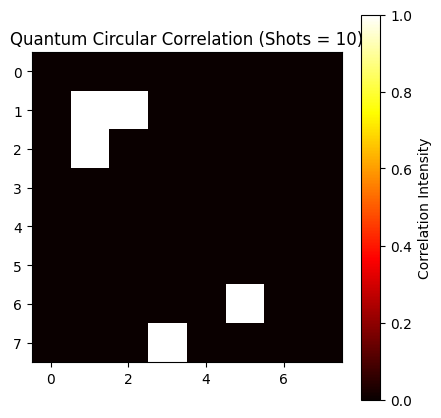

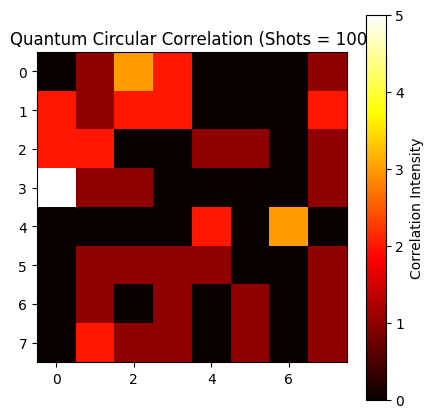

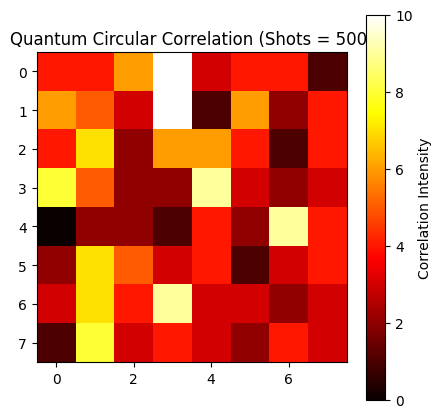

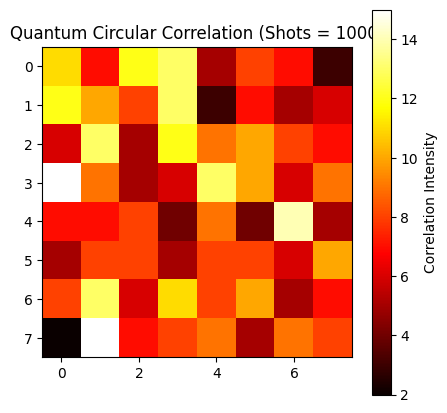

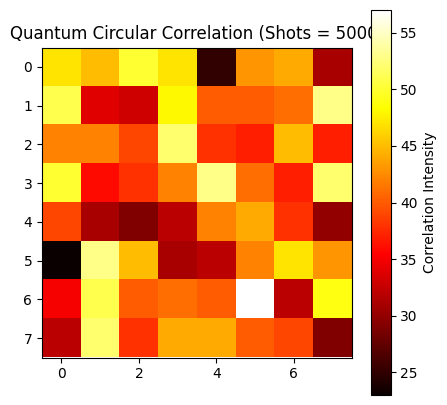

In [6]:
from qiskit_aer import Aer
from qiskit import transpile
import matplotlib.pyplot as plt
import numpy as np

def get_vec_from_counts(counts, qubits):
    vec = np.zeros(2**qubits)
    for k in range(2**qubits):
        key = format(k, '0' + str(qubits) + 'b')
        if key in counts:
            vec[k] = counts[key]
    return vec

# Decompose and add measurements
qc_sampling = qc.copy()
qc_sampling = qc_sampling.decompose()
qc_sampling.measure_all()

# Use Aer simulator for measurement-based sampling
backend = Aer.get_backend('aer_simulator')

# Transpile for the backend
qc_sampling = transpile(qc_sampling, backend)

# Shots to test
shots_list = [10, 100, 500, 1000, 5000]

for shots in shots_list:
    # Reset simulator and run
    backend.set_options(seed_simulator=42)  # for reproducibility
    job = backend.run(qc_sampling, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Convert counts to vector
    correlation = get_vec_from_counts(counts, qc_sampling.num_qubits)
    
    # Reshape to N x N
    correlation = correlation[:N**2]
    correlation = np.reshape(correlation, (N, N))

    # Apply fftshift
    correlation = np.fft.fftshift(correlation)

    # Plot result
    plt.figure(figsize=(5, 5))
    plt.imshow(np.real(correlation), cmap="hot", interpolation="nearest")
    plt.colorbar(label="Correlation Intensity")
    plt.title(f"Quantum Circular Correlation (Shots = {shots})")
    plt.show()


## Amplitude Amplification

The key problem of the algorithm is that only the measurements matter where the lower qubits are in the $\vert 0 \rangle$ state. With amplitude amplification, one can choose amplitudes of the quantum state to become bigger, which in return makes amplitudes smaller that are not elevant for the output information. Amplitude Amplification works by projection operators $P_0,P_G$ and the base circuit $U$. For $r$ amplifications, the circuit takes the form

$$ \left( U P_0 U^\dagger P_G \right)^r \ \ U \vert 00..0\rangle.$$

By this project, you have already implemented $U \vert 00..0\rangle$. 

$P_0$ is the operator which marks the global $\vert00..0\rangle$ state. As a circuit, this works by a multi-controlled Z gate with X gates around it. An exemplaric function to create such a circuit can be found below.

In [7]:
def qc0(n):
    qc_0 = QuantumCircuit(n,name='D0')
    qc_0.x(list(range(n))); qc_0.mcp(np.pi,list(range(n-1)),n-1) ;qc_0.x(list(range(n)))
    return qc_0

qc0(5).draw()

┌───┐       ┌───┐
q_0: ┤ X ├─■─────┤ X ├
     ├───┤ │     ├───┤
q_1: ┤ X ├─■─────┤ X ├
     ├───┤ │     ├───┤
q_2: ┤ X ├─■─────┤ X ├
     ├───┤ │     ├───┤
q_3: ┤ X ├─■─────┤ X ├
     ├───┤ │P(π) ├───┤
q_4: ┤ X ├─■─────┤ X ├
     └───┘       └───┘

$P_G$ is an operator that marks the elements we wish to measure more often (the 'good' elements). In the herein case, these elements are those where the lower qubits are in the $\vert00...0\rangle$ state.

Use the circuits and functions above to create a function which returns the circuit after $r$ amplification steps. $r$ is a tunable integer.

* The code below already gives a blueprint and solves the problem that the state preparation adds reset gates which can not be properly inverted. 
* Also, it already creates a new circuit inside which will be the output. Use mainly .append() for missing blocks 
* The circuit from the previous section (wthout measurements) is $U$. You can create $U^\dagger$ with .inverse()
* $P_0$ should span over all qubits as it marks the global ground state
* $P_G$ marks the ground state on the lower qubits.
* The expression $\left( U P_0 U^\dagger P_G \right)^r$ means to add $P_G$ first, then $U^\dagger$, then $P_0$ and then $U$. This should be repeated $r$ times

C:\Users\Kostiantyn\AppData\Local\Temp\ipykernel_11400\1908045891.py:24: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr,qargs,cargs in U_.data:


An example for r=2:


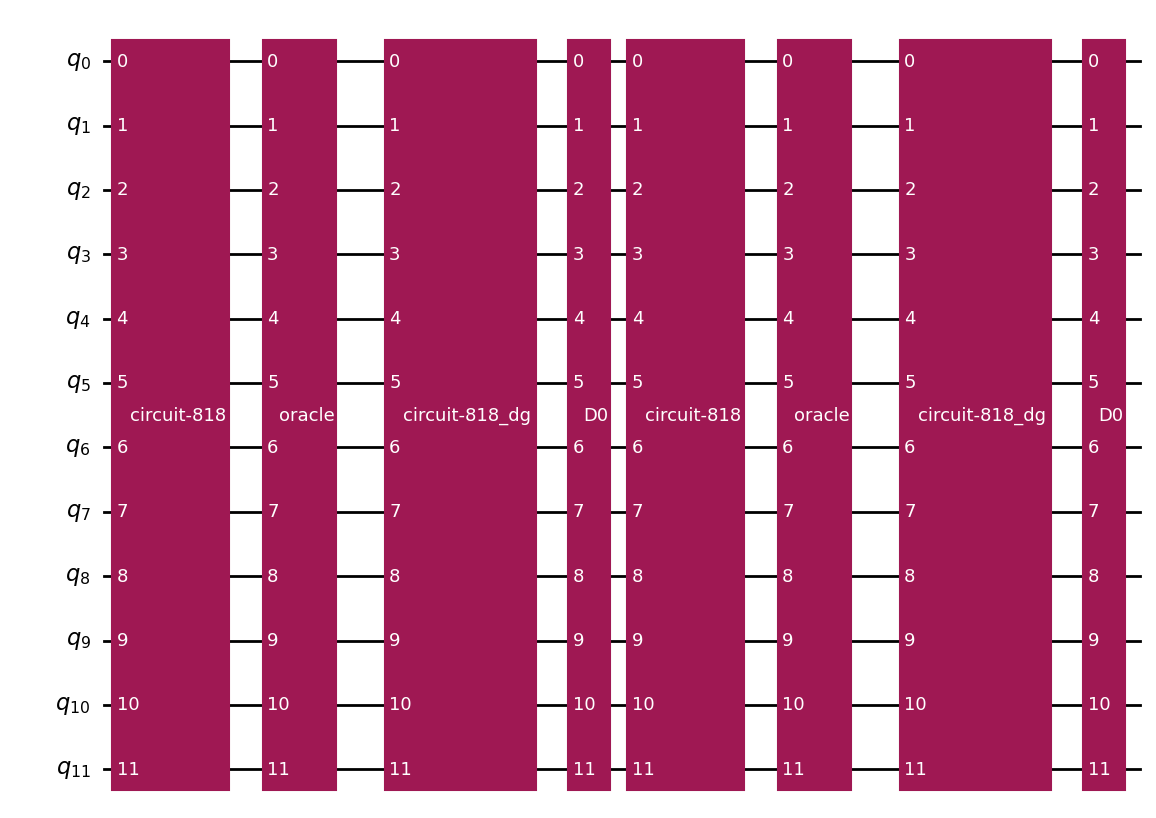

In [44]:
from qiskit import QuantumCircuit, transpile
import numpy as np

def qc0(n):
    qc_0 = QuantumCircuit(n, name='D0')
    qc_0.x(list(range(n)))
    qc_0.mcp(np.pi, list(range(n - 1)), n - 1)
    qc_0.x(list(range(n)))
    return qc_0

def mark_lower_qubits_zero(num_total_qubits, num_lower_qubits):
    """Mark states where lower `num_lower_qubits` are all zero."""
    qc = QuantumCircuit(num_total_qubits, name="oracle")
    lower_qubits = list(range(num_total_qubits - num_lower_qubits, num_total_qubits))
    qc.x(lower_qubits)
    qc.mcp(np.pi, lower_qubits[:-1], lower_qubits[-1])  # Multi-controlled Z
    qc.x(lower_qubits)
    return qc

def amplified_circuit(U, n_, r):
    # Preprocess circuit: remove resets (which can't be inverted)
    U_ = transpile(U, basis_gates=['u3', 'cx', 'cp', 'h', 'x', 'mcx']).copy(name='U')
    U_clean = QuantumCircuit(n_)
    for instr,qargs,cargs in U_.data:
        if instr.name != 'reset':
            U_clean.append(instr, qargs, cargs)

    # Start the amplified circuit
    qc_ = QuantumCircuit(n_)

    for _ in range(r):
        qc_.append(U_clean, range(n_))                              # Apply U
        qc_.append(mark_lower_qubits_zero(n_, 2 * (n_ // 4)), range(n_))  # Oracle
        qc_.append(U_clean.inverse(), range(n_))                    # Apply U†
        qc_.append(qc0(n_), range(n_))                              # D0 diffuser

    return qc_

# Apply amplitude amplification
qc_A = amplified_circuit(qc, 4 * n, 2)

# Show circuit
print("An example for r=2:")
qc_A.draw("mpl")


Plot the resulting correlation map for $r=0,1,2$ with statevector simulations. Observe the evolution of the norm of that image, which indicates how probable it is to measure it.

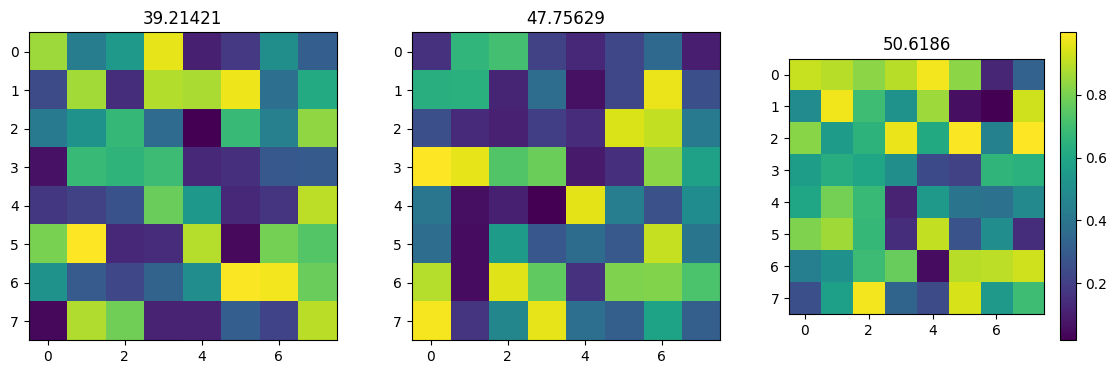

In [159]:
import numpy as np
import matplotlib.pyplot as plt

n=3
# Create subplots to show images
plt.figure(figsize=(14, 4))

for r in range(3):
    # Amplify the circuit
    qc_A = amplified_circuit(qc0(n), 4 * n, r)
    
    # Generate the image
    Ima = get_statevector_image(qc_A)

    # Plot image with norm in the title
    plt.subplot(131 + r)
    plt.imshow((-1)**r * np.real(Ima), cmap='viridis')  # Display the real part of "Ima"
    plt.title(f"{np.round(np.linalg.norm(Ima)**2, 5)}")
    
plt.colorbar() 
plt.show()

Repeat the evaluation from above but with shot based simulations. Replace the norm in the title with the sum of measurements in the plotted image.

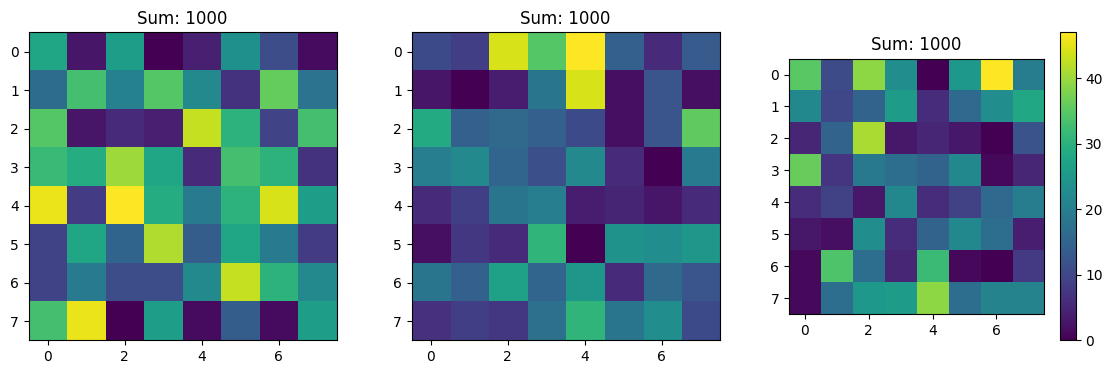

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to create a random measurement outcome based on shots
def get_measurements_image(qc, shots=1000):
    # Simulate measurement outcomes
    probabilities = np.abs(get_statevector_image(qc))**2
    probabilities /= np.sum(probabilities)  # Normalize probabilities
    
    if np.sum(probabilities) == 0:
        raise ValueError("Probabilities cannot be all zeros.")

    measurements = np.random.choice(np.arange(probabilities.size), size=shots, p=probabilities.flatten())
    
    # Create an image representation of the measurements
    measurement_image = np.zeros((8, 8), dtype=int)
    for measurement in measurements:
        x, y = divmod(measurement, 8)  # Map to 8x8 grid
        measurement_image[x, y] += 1
    
    return measurement_image

# Create subplots 
plt.figure(figsize=(14, 4))

for r in range(3):
    # Amplify the circuit
    qc_A = amplified_circuit(qc, 4 * n, r)
    
    # Generate the measurements image
    measurements_image = get_measurements_image(qc_A)

    
    plt.subplot(131 + r)
    plt.imshow(measurements_image, cmap='viridis')  
    plt.title(f"Sum: {np.sum(measurements_image)}")
    
plt.colorbar() 
plt.show()

This point marks the end for the 1 person project. Everything that follows is only necessary for groups with $\geq 2$ participants.

## Sum of Correlation

A problem often encountered in practical applications is that a single cross-correlation is not reliabe enough to identify the correlation peak, for instance due to noise. In those cases, one can use sum of correlation which means that one sums together multiple correlation maps where it is assumed that the displacement / correlation peak is fundamentally equal in all used images. Mathematically, we evaluate
$$ C_\text{map,final} = \sum_{j=1}^J C_\text{map,j}.$$

1. Create 4 different image pairs with the same displacement. Use different random seeds and displace them as before.
2. Add two additional qubits to the circuit. Place a Hadamard gate on each.
3. Load the images conditioned on the lower qubits. For example, prepare the first image pair if the lower qubits are in the $\vert 00 \rangle$ state and the last if they are in the $\vert 11 \rangle$ state.
4. Place Hadamar gates on the last two qubits again. This will realize the sum of the correlation map if those qubits are in the $\vert 00 \rangle$ state after the Hadamard gates.

Further help for 3. is given below:
* Transpile the state preparation as given in the amplitude amplification section. This is mainly necessary because the resets will cause problems otherwise.
* Make this transpiled circuit a controlled gate. You can find commands for this in the Quantum Phase Estimation Seminar or online.
* The easiest way to go from one image pair to the next is to add $X$ gates on the lower qubits and keep the $\vert 1\rangle$-controlled gate-type. For instance, if you iterate over 4 images, it is useful to work with 'j modulo 2' for the X-Gate position. In that case, the $\vert 1 \rangle$ controlled type will implement on the original $\vert 11\rangle$ case. After one X Gate the original $\vert 10\rangle $ state will be the next, followed by original $\vert 00\rangle $ and then $\vert 01\rangle$.

Draw the circuit for 4 image pairs.

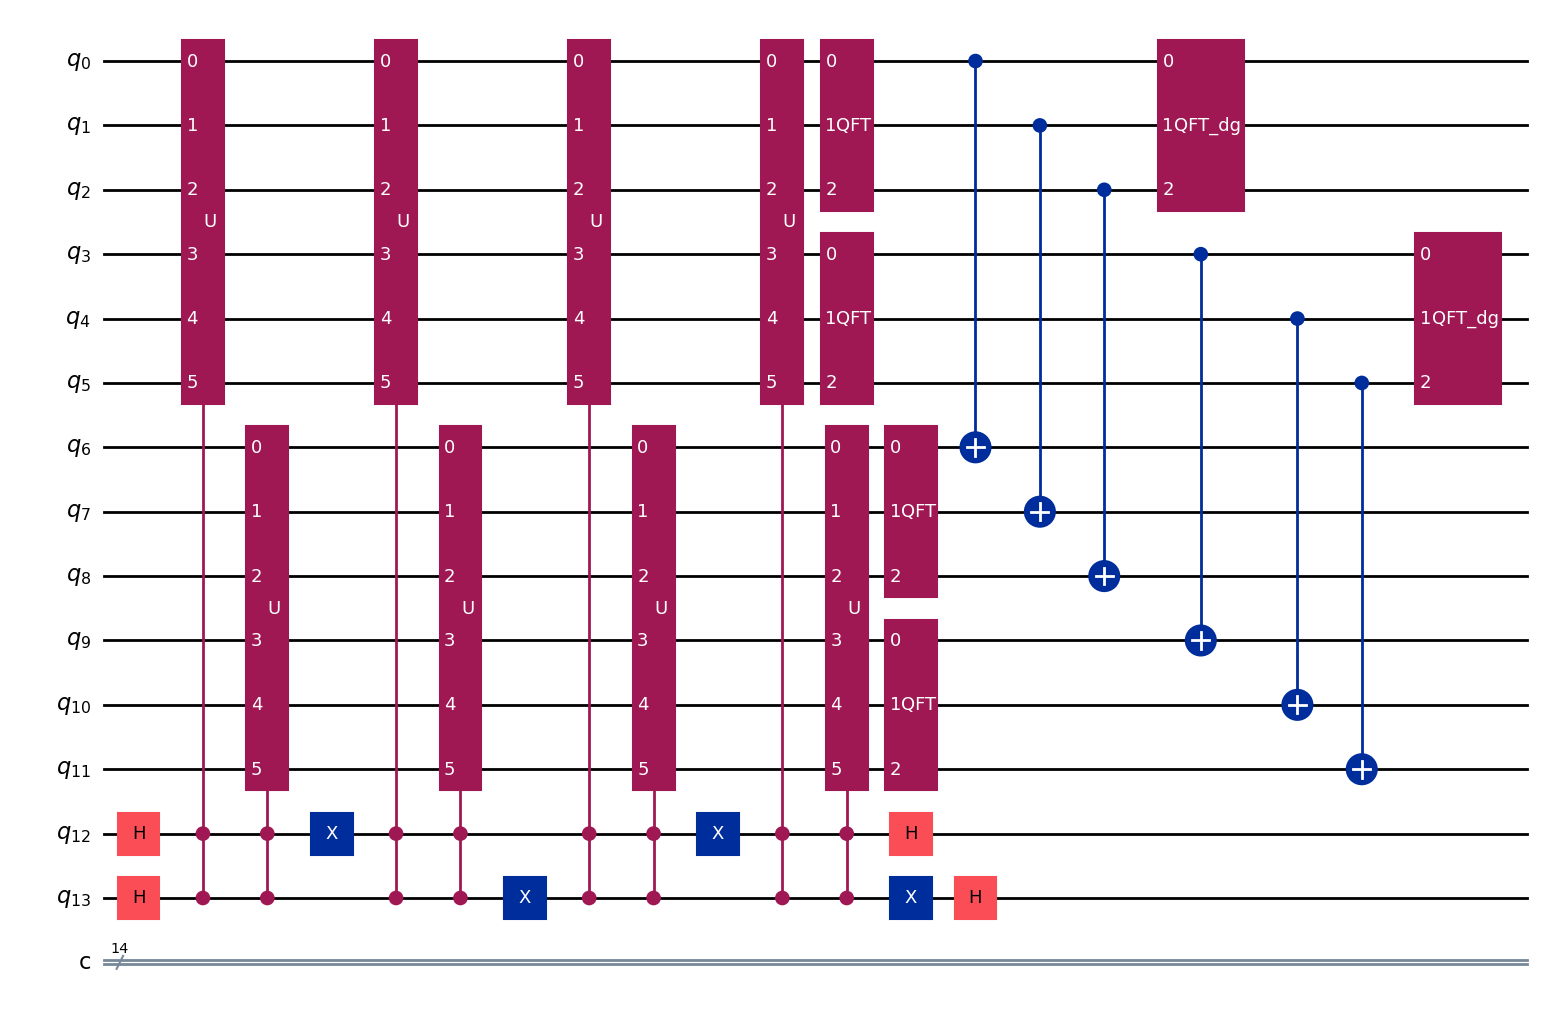

In [184]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

def qc0(n):
    qc_0 = QuantumCircuit(n, name='D0')
    qc_0.x(list(range(n)))
    qc_0.mcp(np.pi, list(range(n-1)), n-1)
    qc_0.x(list(range(n)))
    return qc_0.to_gate(label='U')

n = 6  
qc = QuantumCircuit(14,14)

# Hadamard-гейты на 12 и 13
qc.h(12)
qc.h(13)

# Оператор U
U_gate = qc0(n)

# Первая итерация U
qc.append(U_gate.control(2), [12, 13] + [0, 1, 2, 3, 4, 5])
qc.append(U_gate.control(2), [12, 13] + [6, 7, 8, 9, 10, 11])

# X-гейт на 12
qc.x(12)

# Вторая итерация U
qc.append(U_gate.control(2), [12, 13] + [0, 1, 2, 3, 4, 5])
qc.append(U_gate.control(2), [12, 13] + [6, 7, 8, 9, 10, 11])

# X-гейт на 13
qc.x(13)

# Третья итерация U
qc.append(U_gate.control(2), [12, 13] + [0, 1, 2, 3, 4, 5])
qc.append(U_gate.control(2), [12, 13] + [6, 7, 8, 9, 10, 11])

# X-гейт на 12
qc.x(12)

# Четвертая итерация U + QFT 0-2 и 3-5
QFT_gate = QFT(3).to_gate(label='QFT')
QFT_dg_gate = QFT(3).inverse().to_gate(label='QFT_dg')

qc.append(U_gate.control(2), [12, 13] + [0, 1, 2, 3, 4, 5])
qc.append(U_gate.control(2), [12, 13] + [6, 7, 8, 9, 10, 11])
qc.append(QFT_gate, [0, 1, 2])
qc.append(QFT_gate, [3, 4, 5])

# QFT 6-8 и 9-11, H-12, X-13
qc.append(QFT_gate, [6, 7, 8])
qc.append(QFT_gate, [9, 10, 11])
qc.h(12)
qc.x(13)

# X-гейты
qc.h(13)
qc.cx(0, 6)
qc.cx(1, 7)
qc.cx(2, 8)

# QFT_dg 0-2, X 9-3, X 10-4, X 11-5, QFT_dg 3-5
qc.append(QFT_dg_gate, [0, 1, 2])
qc.cx(3, 9)
qc.cx(4, 10)
qc.cx(5, 11)
qc.append(QFT_dg_gate, [3, 4, 5])

qc.draw('mpl')


Evaluate this circuit with a statevector simulation and verify whether you can identify the correlation peak at the position where it is expected.

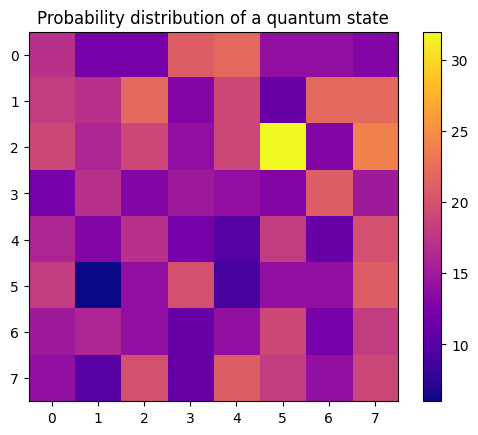

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import QFT

backend = AerSimulator()
transpiled_qc = transpile(qc, backend)

# Running the simulation
job = backend.run(transpiled_qc, shots=1024)
result = job.result()
results = result.get_counts()

# Visualization of results
counts = np.zeros((8, 8))

# Fill the array with values from results
for key, value in results.items():
    index = int(key, 2)  # Convert a bit string to a number
    x, y = index // 8, index % 8  # Determine the coordinates on the 8x8 grid
    if x < 8 and y < 8:  # Сhecking that the indices are within acceptable limits
        counts[x][y] += value

plt.imshow(counts, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title("Probability distribution of a quantum state")
plt.show()


Adapt and/or use the amplitude amplification routine from above to identify the optimal amount of amplifications. In this project, this means that we want the maximal norm of the correlation map while the amount of amplifications is minimal.

* It should be checked, that the projectors span appropriately. As we have two additional qubits, $P_0$ still spans over all qubits while $P_G$ should also account for the $\vert 00 \rangle$ state on the two additional qubits.
* A short research about amplitude amplification may gives you a good estimate about the amount of amplifications. The simulations here can take some minutes because the circuits are both large by multiple images and deep by multiple amplifications

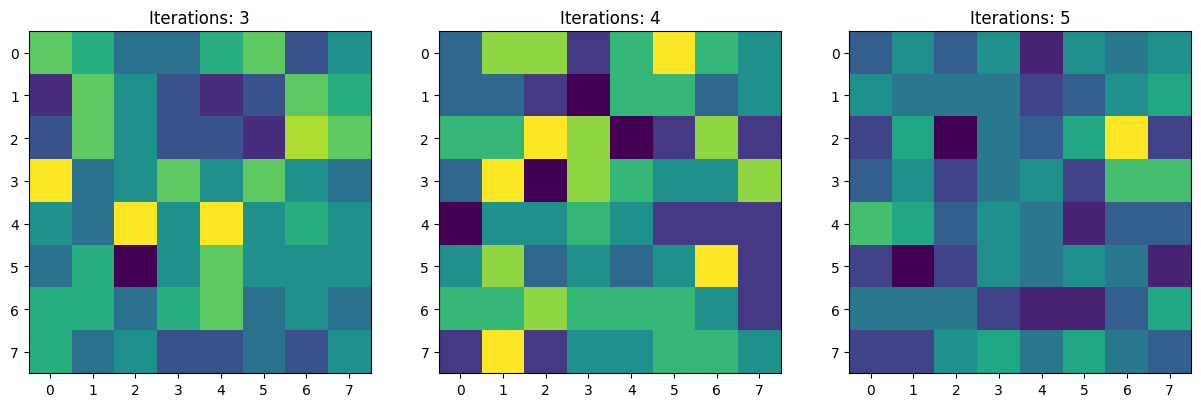

In [205]:
from qiskit import QuantumCircuit, transpile, assemble
import numpy as np
import matplotlib.pyplot as plt

# Function to create the quantum circuit for amplitude amplification
def create_amplitude_amplification_circuit(n, iterations):
    # Setup quantum circuit
    qc = QuantumCircuit(n + 2, n + 2)  # +2 for additional qubits, +2 for classical bits
    qc.h(range(n + 2))  # Hadamard on all qubits

    # Apply the oracle and reflection as many times as iterations
    U_gate = qc0(n)  # Get your U gate defined above
    for _ in range(iterations):
        qc.append(U_gate.control(2), [n, n + 1] + list(range(n)))  # Applying U
        # Reflection step to amplify the desired outcome
        for qubit in range(n + 2):
            qc.x(qubit)  # Apply X-gate
        qc.append(U_gate.control(2), [n, n + 1] + list(range(n)))  # Apply U again
        for qubit in range(n + 2):
            qc.x(qubit)  # Apply X-gate again

    # Add measurements
    qc.measure(range(n + 2), range(n + 2))

    return qc

# Simulation parameters
n = 6  # Number of working qubits
backend = Aer.get_backend('qasm_simulator')

# Determine optimal number of iterations
initial_success_probability = 0.1  # Hypothetical initial success probability
iterations = int(np.ceil((np.pi / 4) * (1 / np.sqrt(initial_success_probability * (1 - initial_success_probability)))))

# Create and run the circuit three times with slight variations
results_list = []
for i in range(3):
    qc_amplified = create_amplitude_amplification_circuit(n, iterations + i)  # Vary iterations slightly
    transpiled_qc = transpile(qc_amplified, backend)
    job = backend.run(transpiled_qc, shots=1024)
    result = job.result()
    results_list.append(result.get_counts())

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, results in enumerate(results_list):
    counts = np.zeros((8, 8))
    for key, value in results.items():
        index = int(key, 2)
        x, y = index // 8, index % 8
        if x < 8 and y < 8:
            counts[x][y] += value

    axes[i].imshow(counts, cmap='viridis', interpolation='nearest')
    axes[i].set_title(f"Iterations: {iterations + i}")

plt.show()

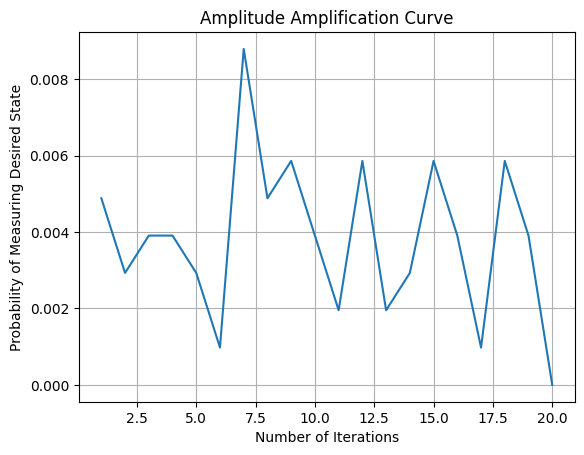

In [207]:
from qiskit import QuantumCircuit, transpile, assemble
import numpy as np
import matplotlib.pyplot as plt

def qc0(n):
    qc_0 = QuantumCircuit(n, name='D0')
    qc_0.x(list(range(n)))
    qc_0.mcp(np.pi, list(range(n-1)), n-1)
    qc_0.x(list(range(n)))
    return qc_0.to_gate(label='U')

def create_amplitude_amplification_circuit(n, iterations):
    qc = QuantumCircuit(n + 2, n + 2)
    qc.h(range(n + 2))
    U_gate = qc0(n)
    for _ in range(iterations):
        qc.append(U_gate.control(2), [n, n + 1] + list(range(n)))
        for qubit in range(n + 2):
            qc.x(qubit)
        qc.append(U_gate.control(2), [n, n + 1] + list(range(n)))
        for qubit in range(n + 2):
            qc.x(qubit)
    qc.measure(range(n + 2), range(n + 2))
    return qc

n = 6
backend = Aer.get_backend('qasm_simulator')
initial_success_probability = 0.1
max_iterations = 20  # Increase the number of iterations to better demonstrate the curve

iterations_list = list(range(1, max_iterations + 1))
success_probabilities = []

for iterations in iterations_list:
    qc_amplified = create_amplitude_amplification_circuit(n, iterations)
    transpiled_qc = transpile(qc_amplified, backend)
    job = backend.run(transpiled_qc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    # Suppose the desired state is the state with all qubits in |1>
    desired_state = '1' * (n + 2)
    success_count = counts.get(desired_state, 0)
    success_probability = success_count / 1024
    success_probabilities.append(success_probability)

plt.plot(iterations_list, success_probabilities)
plt.xlabel('Number of Iterations')
plt.ylabel('Probability of Measuring Desired State')
plt.title('Amplitude Amplification Curve')
plt.grid(True)
plt.show()